In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [6]:
data = pd.read_csv("P1_Churn_Modelling.csv")

In [7]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [9]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [10]:
data.shape

(10000, 14)

In [11]:
data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

# Preprocessing

## Explore missing values

In [12]:
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [13]:
data.duplicated().sum()

np.int64(0)

## Explore category data

In [14]:
category = [data.columns[col] for col in range(len(data.columns)) if data.dtypes[col] == "O"]
category

['Surname', 'Geography', 'Gender']

Surname Column

In [15]:
data['Surname'].unique()

array(['Hargrave', 'Hill', 'Onio', ..., 'Kashiwagi', 'Aldridge',
       'Burbidge'], dtype=object)

In [16]:
data['Surname'].nunique()

2932

Geography Column

In [17]:
data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

<Axes: xlabel='Geography', ylabel='Exited'>

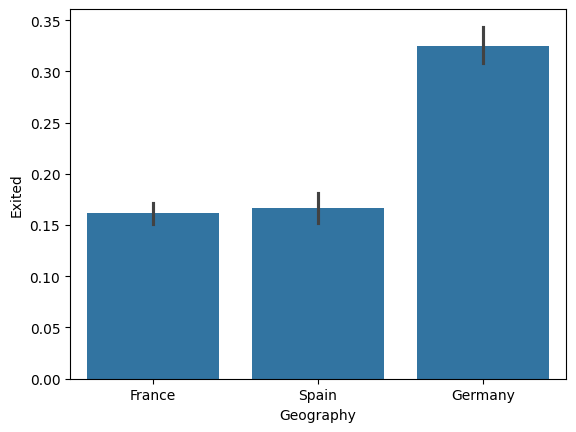

In [18]:
sns.barplot(data=data, x='Geography', y='Exited')

Gender column

In [19]:
data['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [20]:
data['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

<Axes: xlabel='Gender', ylabel='Exited'>

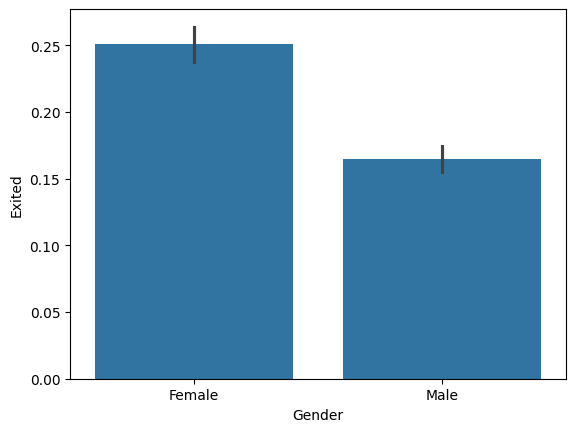

In [21]:
sns.barplot(data=data, x='Gender', y='Exited')

## Explore numeric data

In [22]:
numeric = [col for col in data.columns if col not in category]
numeric

['RowNumber',
 'CustomerId',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

RowNumber column

In [23]:
data['RowNumber'].unique()

array([    1,     2,     3, ...,  9998,  9999, 10000])

In [24]:
data['RowNumber'].nunique()

10000

In [25]:
data['RowNumber'].value_counts()

RowNumber
9984    1
9983    1
9982    1
9981    1
9980    1
       ..
5       1
4       1
3       1
2       1
1       1
Name: count, Length: 10000, dtype: int64

CustomerId Column

In [26]:
data['CustomerId'].nunique()

10000

CreditScore Column

In [27]:
data['CreditScore'].nunique()

460

In [28]:
data['CreditScore'].value_counts().sort_values()

CreditScore
419      1
373      1
382      1
412      1
358      1
      ... 
667     53
705     53
655     54
678     63
850    233
Name: count, Length: 460, dtype: int64

In [29]:
data.groupby('Exited')['CreditScore'].describe()

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,7963.0,651.853196,95.653837,405.0,585.0,653.0,718.0,850.0
1,2037.0,645.351497,100.321503,350.0,578.0,646.0,716.0,850.0


Age Column

In [30]:
data['Age'].nunique()

70

In [31]:
data['Age'].unique()

array([42, 41, 39, 43, 44, 50, 29, 27, 31, 24, 34, 25, 35, 45, 58, 32, 38,
       46, 36, 33, 40, 51, 61, 49, 37, 19, 66, 56, 26, 21, 55, 75, 22, 30,
       28, 65, 48, 52, 57, 73, 47, 54, 72, 20, 67, 79, 62, 53, 80, 59, 68,
       23, 60, 70, 63, 64, 18, 82, 69, 74, 71, 76, 77, 88, 85, 84, 78, 81,
       92, 83])

In [32]:
data['Age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64

In [33]:
data['Age'].value_counts()

Age
37    478
38    477
35    474
36    456
34    447
     ... 
84      2
82      1
88      1
85      1
83      1
Name: count, Length: 70, dtype: int64

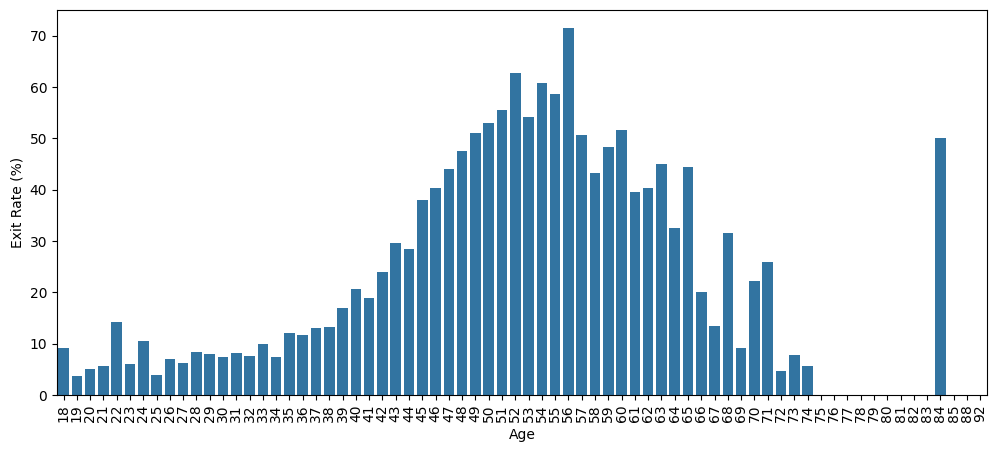

In [34]:
Age_exit_rate = ( data.groupby('Age')['Exited'].mean() ) * 100

plt.figure(figsize=(12, 5))
sns.barplot(x=Age_exit_rate.index, y=Age_exit_rate.values)
plt.xticks(rotation=90)
plt.xlabel('Age')
plt.ylabel('Exit Rate (%)')
plt.show()


Tenure Column

Tenure usually refers to the number of years a customer has been with the bank.

In [35]:
data['Tenure'].unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0])

In [36]:
data['Tenure'].value_counts().sort_values()

Tenure
0      413
10     490
6      967
9      984
4      989
3     1009
5     1012
8     1025
7     1028
1     1035
2     1048
Name: count, dtype: int64

<Axes: xlabel='Exited', ylabel='Tenure'>

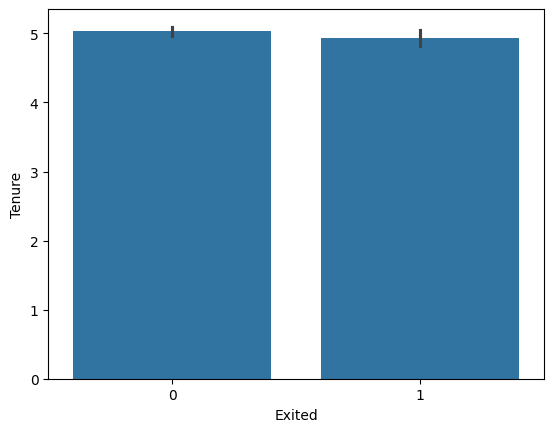

In [37]:
sns.barplot(x=data['Exited'], y=data['Tenure'])

Balance Column

Balance likely refers to the amount of money a customer has in their bank account.

In [38]:
data['Balance'].nunique()

6382

In [39]:
data['Balance'].value_counts().sort_values()

Balance
85216.61        1
110112.54       1
125489.40       1
113957.01       1
85311.70        1
             ... 
116363.37       1
93017.47        1
130170.82       2
105473.74       2
0.00         3617
Name: count, Length: 6382, dtype: int64

In [40]:
data.groupby('Exited')['Balance'].describe()

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,7963.0,72745.296779,62848.040701,0.0,0.00,92072.68,126410.28,221532.80
1,2037.0,91108.539337,58360.794816,0.0,38340.02,109349.29,131433.33,250898.09


In [41]:
# data = data[data['Balance'] != 0]
# data.reset_index(drop=True, inplace=True)

NumOfProducts Columns

In [42]:
data['NumOfProducts'].unique()

array([1, 3, 2, 4])

In [43]:
data['NumOfProducts'].value_counts()

NumOfProducts
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64

<Axes: xlabel='NumOfProducts', ylabel='Exited'>

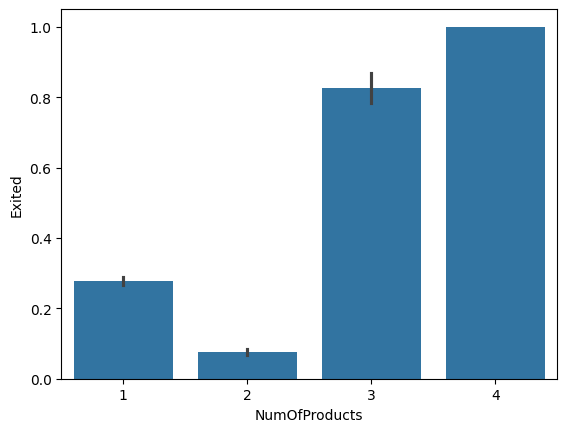

In [44]:
sns.barplot(x=data['NumOfProducts'], y=data['Exited'])

In [45]:
# data = data[data['Balance'] != 0]
# data.reset_index(drop=True, inplace=True)

HasCrCard Column

In [46]:
data['HasCrCard'].value_counts()

HasCrCard
1    7055
0    2945
Name: count, dtype: int64

<Axes: xlabel='HasCrCard', ylabel='Exited'>

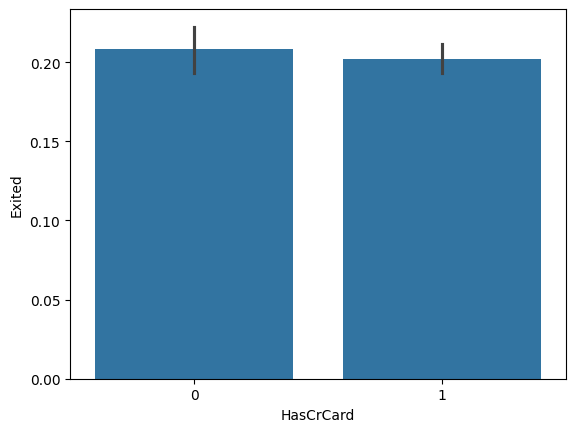

In [47]:
sns.barplot(x=data['HasCrCard'], y=data['Exited'])


IsActiveMember Column

In [48]:
data['IsActiveMember'].value_counts()

IsActiveMember
1    5151
0    4849
Name: count, dtype: int64

<Axes: xlabel='IsActiveMember', ylabel='Exited'>

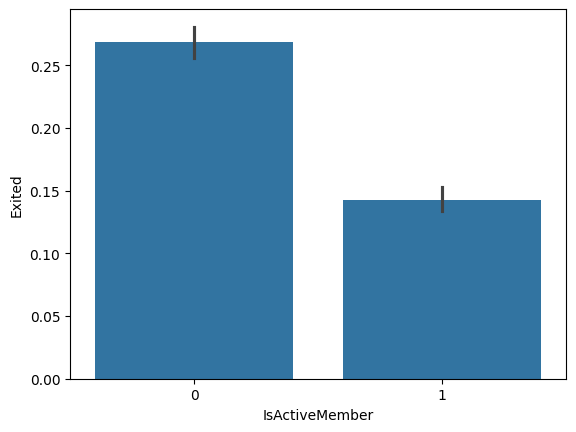

In [49]:
sns.barplot(x=data['IsActiveMember'], y=data['Exited'])


EstimatedSalary Column

In [50]:
data['EstimatedSalary'].nunique()

9999

In [51]:
# imbalanced
data['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [52]:
# sns.barplot(data['Exited'])

## Explore Outiers

<Axes: xlabel='Exited', ylabel='EstimatedSalary'>

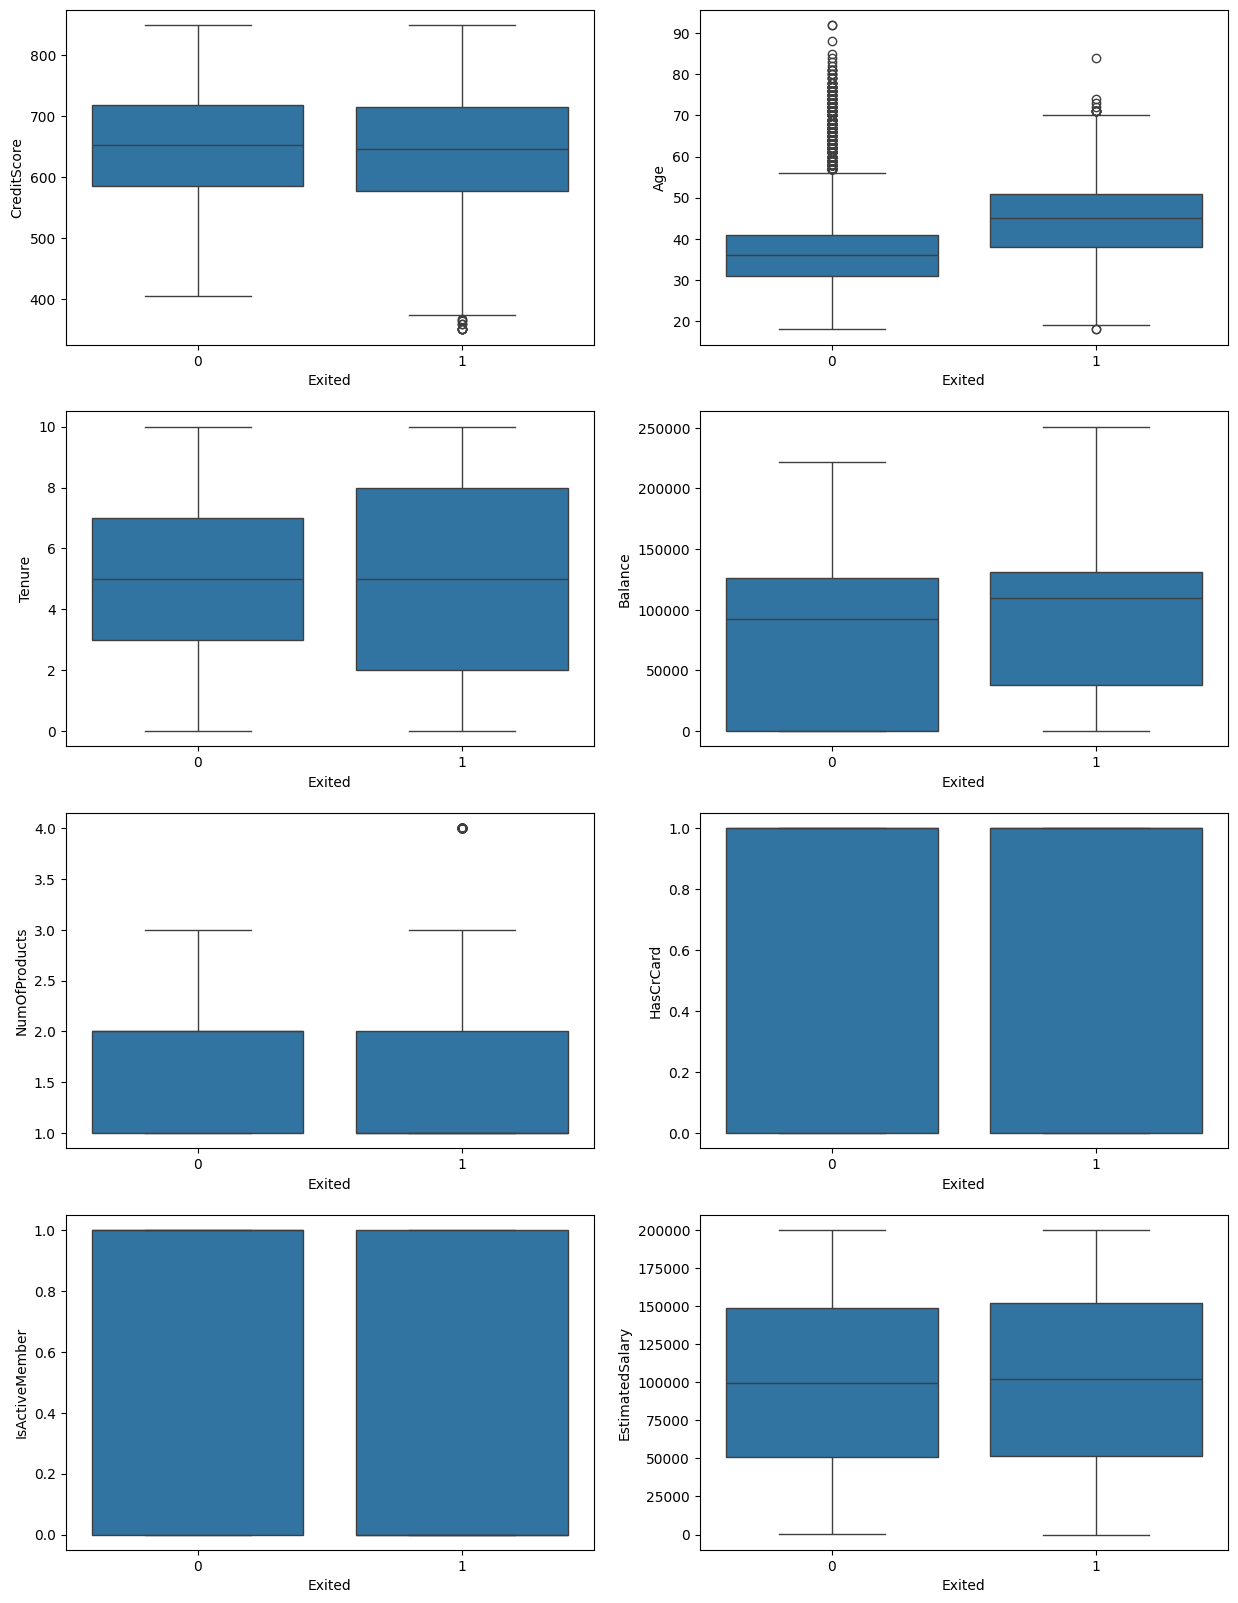

In [53]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
sns.boxplot(x=data['Exited'], y=data["CreditScore"], ax = axes[0][0])
sns.boxplot(x=data['Exited'], y=data["Age"], ax = axes[0][1])
sns.boxplot(x=data['Exited'], y=data["Tenure"], ax = axes[1][0])
sns.boxplot(x=data['Exited'], y=data["Balance"], ax = axes[1][1])
sns.boxplot(x=data['Exited'], y=data["NumOfProducts"], ax = axes[2][0])
sns.boxplot(x=data['Exited'], y=data["HasCrCard"], ax = axes[2][1])
sns.boxplot(x=data['Exited'], y=data["IsActiveMember"], ax = axes[3][0])
sns.boxplot(x=data['Exited'], y=data["EstimatedSalary"], ax = axes[3][1])




## Handling Outliers

In [54]:
def detect_IQR(column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return IQR, lower_bound, upper_bound


In [55]:
def handling_outliers_median(column):
    lower_bound = detect_IQR(column)[1]
    upper_bound = detect_IQR(column)[2]
    medain_value = data[column].median()
    data[column] = data[column].apply(lambda value : medain_value if (value < lower_bound) or (value > upper_bound) else value)

In [56]:
def handling_outliers_mean(column):
    lower_bound = detect_IQR(column)[1]
    upper_bound = detect_IQR(column)[2]
    mean_value = data[column].mean()
    data[column] = data[column].apply(lambda value : mean_value if (value < lower_bound) or (value > upper_bound) else value)

CreditScore Column

In [57]:
handling_outliers_median('CreditScore')
data.loc[data['CreditScore'] > 400]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619.0,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608.0,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502.0,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699.0,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850.0,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771.0,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516.0,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709.0,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772.0,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


<Axes: xlabel='Exited', ylabel='CreditScore'>

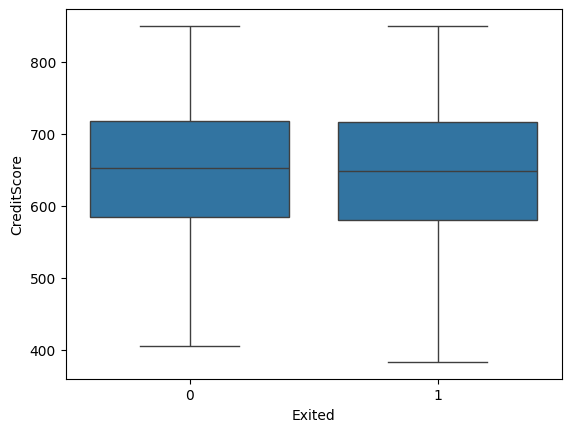

In [58]:
sns.boxplot(x=data['Exited'], y=data["CreditScore"])

<Axes: ylabel='CreditScore'>

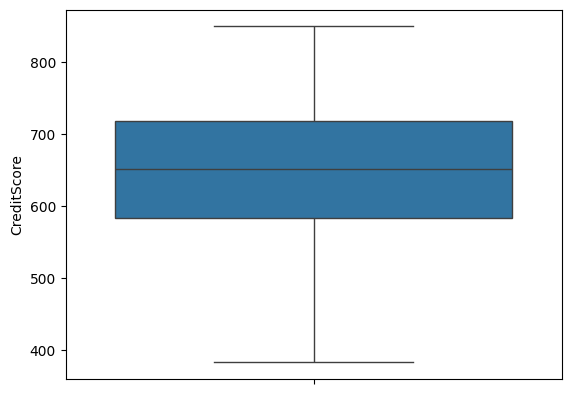

In [59]:
sns.boxplot(data["CreditScore"])

Age Column

In [60]:
handling_outliers_median('Age')

<Axes: ylabel='Age'>

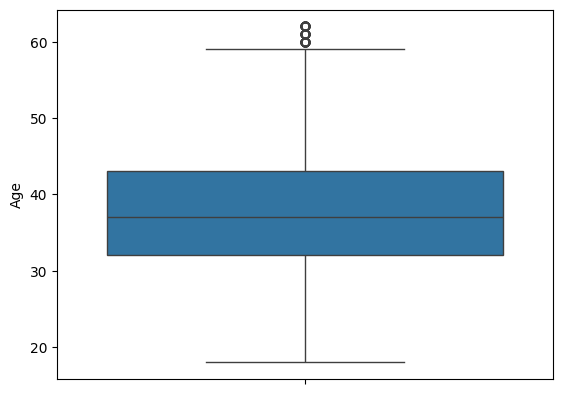

In [61]:
sns.boxplot(data["Age"])

In [62]:
data = data.loc[data['Age'] < 58 ]

In [63]:
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619.0,France,Female,42.0,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608.0,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502.0,France,Female,42.0,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699.0,France,Female,39.0,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850.0,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771.0,France,Male,39.0,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516.0,France,Male,35.0,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709.0,France,Female,36.0,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772.0,Germany,Male,42.0,3,75075.31,2,1,0,92888.52,1


<Axes: ylabel='Age'>

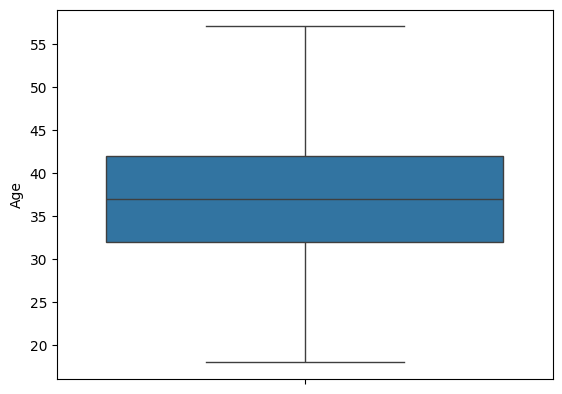

In [64]:
sns.boxplot(data["Age"])

NumOfProducts Column

In [65]:
handling_outliers_mean('NumOfProducts')

<Axes: xlabel='Exited', ylabel='NumOfProducts'>

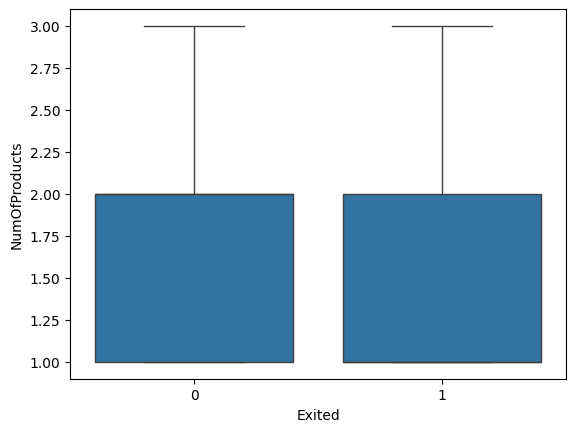

In [66]:
sns.boxplot(x=data['Exited'], y=data["NumOfProducts"])

<Axes: ylabel='EstimatedSalary'>

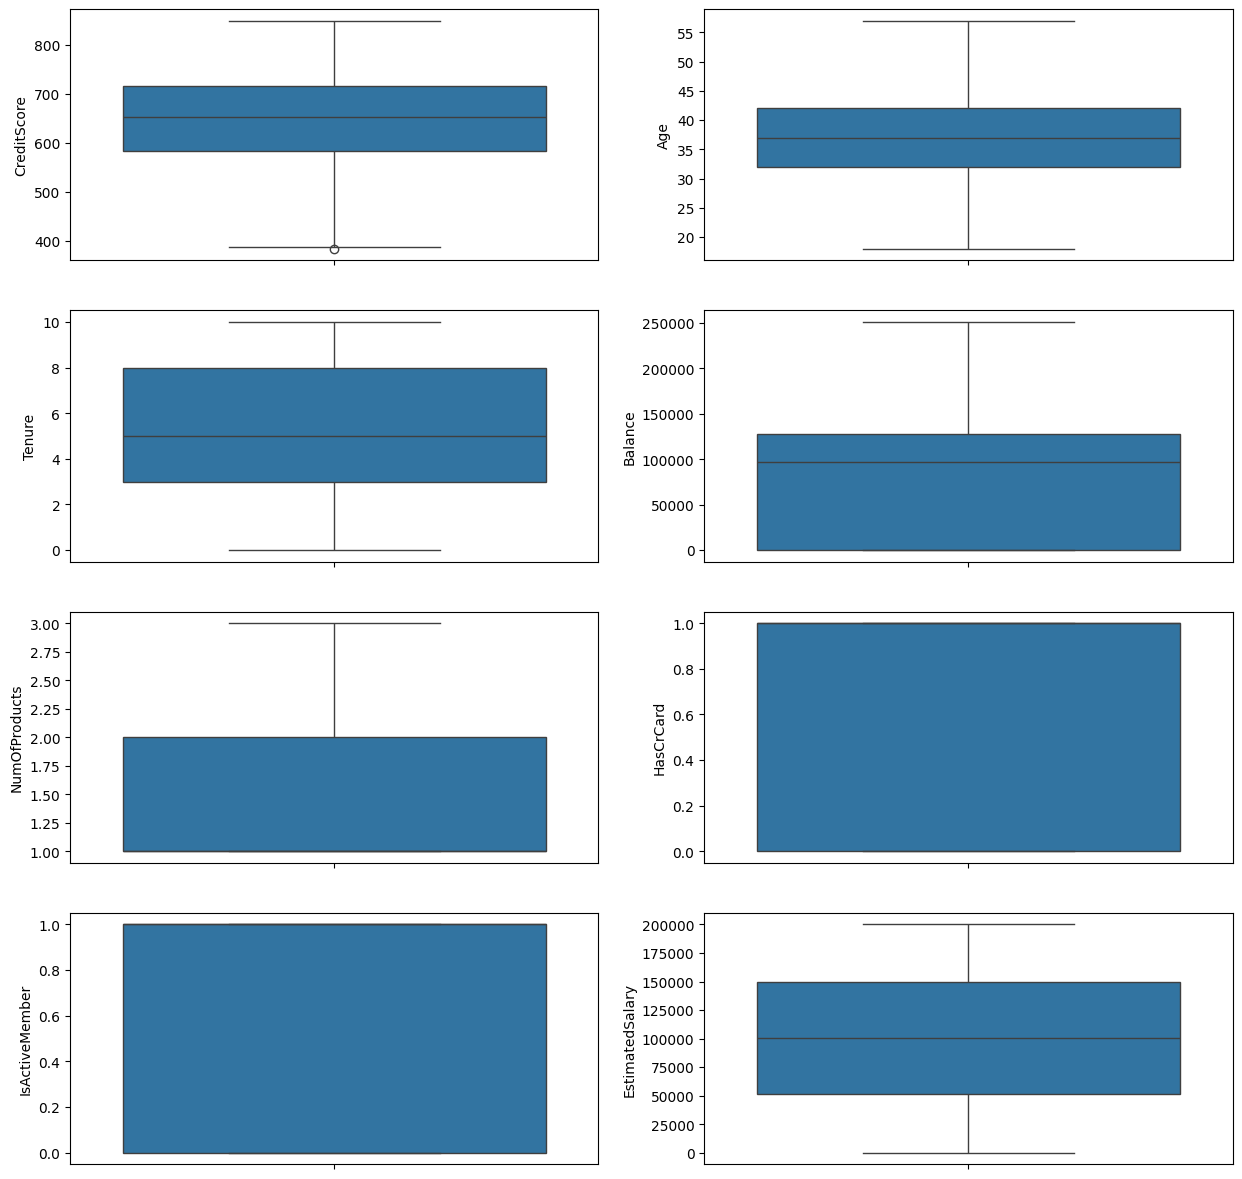

In [67]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
sns.boxplot(data["CreditScore"], ax = axes[0][0])
sns.boxplot(data["Age"], ax = axes[0][1])
sns.boxplot(data["Tenure"], ax = axes[1][0])
sns.boxplot(data["Balance"], ax = axes[1][1])
sns.boxplot(data["NumOfProducts"], ax = axes[2][0])
sns.boxplot(data["HasCrCard"], ax = axes[2][1])
sns.boxplot(data["IsActiveMember"], ax = axes[3][0])
sns.boxplot(data["EstimatedSalary"], ax = axes[3][1])


## Feature Selection

In [68]:
data.drop(columns=['Surname', 'RowNumber', 'CustomerId'], inplace=True)

In [69]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619.0,France,Female,42.0,2,0.00,1.0,1,1,101348.88,1
1,608.0,Spain,Female,41.0,1,83807.86,1.0,0,1,112542.58,0
2,502.0,France,Female,42.0,8,159660.80,3.0,1,0,113931.57,1
3,699.0,France,Female,39.0,1,0.00,2.0,0,0,93826.63,0
4,850.0,Spain,Female,43.0,2,125510.82,1.0,1,1,79084.10,0


## Encoding

In [70]:
encoding_gender = {
    'Male':0,
    'Female':1
}

data['Gender'] = data['Gender'].map(encoding_gender)
data['Gender']

0       1
1       1
2       1
3       1
4       1
       ..
9995    0
9996    0
9997    1
9998    0
9999    1
Name: Gender, Length: 9704, dtype: int64

In [71]:
encoding_columns = ['Geography'] 

In [72]:
data = pd.get_dummies(data=data, columns=encoding_columns, drop_first=True).astype('int')

In [73]:
data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,1,42,2,0,1,1,1,101348,1,0,0
1,608,1,41,1,83807,1,0,1,112542,0,0,1
2,502,1,42,8,159660,3,1,0,113931,1,0,0
3,699,1,39,1,0,2,0,0,93826,0,0,0
4,850,1,43,2,125510,1,1,1,79084,0,0,1


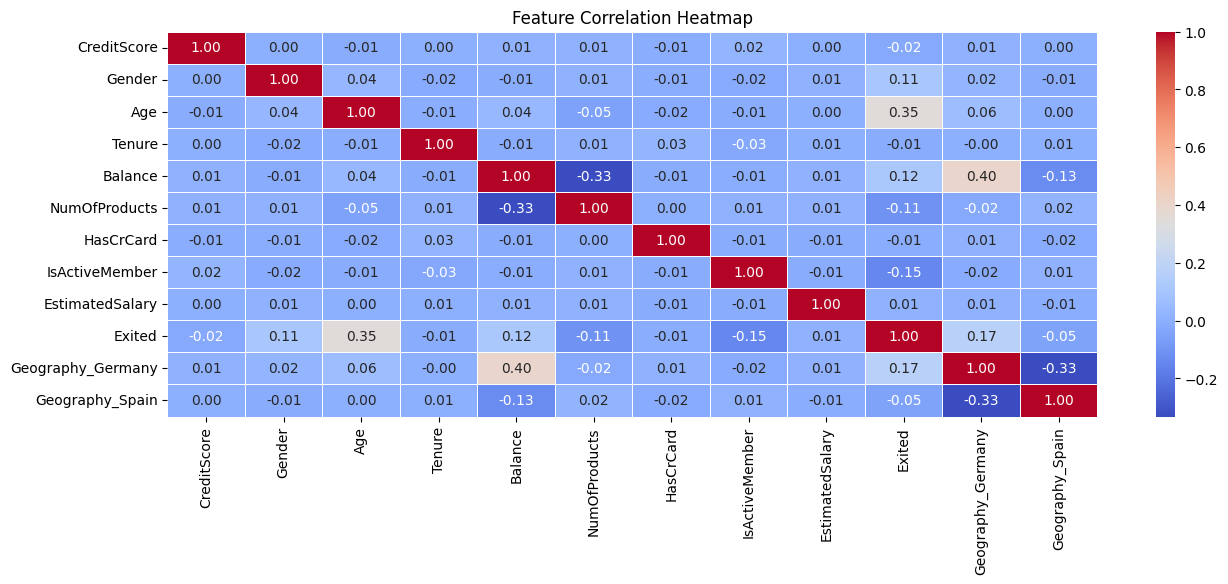

In [74]:
# columns = ['CreditScore','Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary' ,'Exited']
corr_matrix = data.corr()

plt.figure(figsize=(15, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Feature Correlation Heatmap")
plt.show()

In [75]:
# cor_target = abs(corr_matrix['Exited'])
# cor_target

In [76]:
# relevant_features = cor_target[cor_target > 0.2]
# relevant_features

In [77]:
# names =[index for index, value in relevant_features.items()]
# names.remove('Exited')
# names

## Splitting data into training and testing sets

In [78]:
input = data.drop(columns=['Exited'])
output = data['Exited']

In [79]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.2, random_state=42)

In [80]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)


## Standarization

In [81]:
scaler_columns = ['Balance', 'CreditScore', 'Age', 'Tenure', 'EstimatedSalary']

In [82]:
scaler = StandardScaler()
x_train[scaler_columns] = scaler.fit_transform(x_train[scaler_columns])
x_test[scaler_columns] = scaler.transform(x_test[scaler_columns])

In [83]:
x_train[scaler_columns].head()

,Balance,CreditScore,Age,Tenure,EstimatedSalary
2205,-1.218457,-1.485750,0.107249,-1.041659,1.187933
1364,0.771626,2.069028,0.234438,-0.694707,0.351222
1649,-1.218457,0.828504,0.488815,-0.347756,-1.355631
7129,0.386993,2.069028,-0.528694,-0.694707,0.632429
7808,0.822358,-0.505841,2.269457,0.693098,0.683418


In [84]:
x_test[scaler_columns].head()

,Balance,CreditScore,Age,Tenure,EstimatedSalary
496,1.483322,-0.307774,-0.655883,0.346147,0.014954
7729,0.835540,2.069028,-0.274317,-1.041659,-0.430184
9061,0.792862,-0.881125,0.107249,-1.388610,0.133012
1735,0.658914,-0.099283,-0.910260,1.040050,-0.665135
6411,-0.647372,0.213455,-2.054958,-1.388610,-1.242689


# Model

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Before SMOTE:", Counter(y_train))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({0: 6237, 1: 1526})
After SMOTE: Counter({0: 6237, 1: 6237})


In [89]:
# Define parameter grids
param_grids = {
    'LogisticRegression': {
        'max_iter': [500, 1000, 1500],
        'C': [0.01, 0.1, 1, 10],
        'class_weight': [None, 'balanced']
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'GaussianNB': {},
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5, 10],
        'class_weight': [None, 'balanced']
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto'],
        'class_weight': [None, 'balanced']
    }
}

# Define models
models = {
    'LogisticRegression': LogisticRegression(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GaussianNB': GaussianNB(),
    'RandomForestClassifier': RandomForestClassifier(),
    'SVC': SVC()
}

# Perform Grid Search
best_models = {}
for name, model in models.items():
    print(f"Tuning {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(x_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best accuracy: {grid_search.best_score_}\n")

Tuning LogisticRegression...
Best parameters for LogisticRegression: {'C': 10, 'class_weight': None, 'max_iter': 500}
Best accuracy: 0.8336971674378157

Tuning KNeighborsClassifier...
Best parameters for KNeighborsClassifier: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Best accuracy: 0.8376920127986406

Tuning GaussianNB...
Best parameters for GaussianNB: {}
Best accuracy: 0.8316355607039252

Tuning RandomForestClassifier...
Best parameters for RandomForestClassifier: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best accuracy: 0.8619086105376358

Tuning SVC...
Best parameters for SVC: {'C': 10, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}
Best accuracy: 0.8550817838437078



In [104]:
model = RandomForestClassifier(class_weight = None, max_depth= 10, min_samples_leaf= 5, min_samples_split= 2, n_estimators= 100)


In [ ]:
# model = LogisticRegression()
# array([[1514,   49],
#        [ 276,  102]])
# auc_score = 0.80
# Recal : 0.94      ****
# Precision : 0.97  ****
# F1_score : 0.95   ****
# Accuracy : 0.91   ****
# Training Accuracy: 0.83
# Test Accuracy: 0.83


# model = KNeighborsClassifier(n_neighbors=5)
# array([[1523,   84],
    #    [ 245,  148]])
# auc_score = 0.77   -------
# Recal : 0.91
# Precision : 0.95   
# F1_score : 0.93    
# Accuracy : 0.88
# Training Accuracy: 0.87
# Test Accuracy: 0.84   ***


# from sklearn.naive_bayes import GaussianNB
# model = GaussianNB()
# array([[1508,   99],
#        [ 230,  163]])
# Recal : 0.90
# Precision : 0.94
# F1_score : 0.92   
# Accuracy : 0.86
# auc_score = 0.81
# Training Accuracy: 0.82
# Test Accuracy: 0.84   ***

# model = RandomForestClassifier(max_depth=10, random_state=42)

# array([[1523,   40],
#        [ 243,  135]])
# auc_score = 0.85   ****
# Recal : 0.92
# Precision : 0.97
# F1_score : 0.95
# Accuracy : 0.90
# Training Accuracy: 0.90
# Test Accuracy: 0.85 ****

In [ ]:
# model = LogisticRegression(max_iter=1000, C=0.01, class_weight='balanced')
# array([[1169,  438],
#        [ 113,  280]])
# auc_score = 0.80
# Recal : 0.81
# Precision : 0.73
# F1_score : 0.77
# Accuracy : 0.67
# Training Accuracy: 0.73
# Test Accuracy: 0.72


# model = RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=10, min_samples_split=10, min_samples_leaf=5)
# array([[1366,  241],
#        [ 125,  268]])
# auc_score = 0.85   ****
# Recal : 0.84
# Precision : 0.87
# F1_score : 0.85
# Accuracy : 0.78
# Training Accuracy: 0.88
# Test Accuracy: 0.82


# model = RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)
# array([[1415,  148],
#        [ 168,  210]])
# auc_score = 0.85   ****
# Recal : 0.87
# Precision : 0.91
# F1_score : 0.89
# Accuracy : 0.82
# Training Accuracy: 0.91
# Test Accuracy: 0.84 ****


# from sklearn.svm import SVC
# model = svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42)
# array([[1266,  341],
#        [ 103,  290]])
# Recal : 0.81
# Precision : 0.79
# F1_score : 0.80
# Accuracy : 0.71
# Training Accuracy: 0.80
# Test Accuracy: 0.78


In [105]:
scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=kf, scoring='r2')

In [106]:
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=10, min_samples_leaf=5)

In [107]:
y_pred = model.predict(x_test)

In [108]:
y_prob = model.predict_proba(x_test)[:,1]
y_prob[:20]

array([0.29215295, 0.35650916, 0.20578695, 0.36773694, 0.367647  ,
       0.11126006, 0.23456795, 0.08769029, 0.18116656, 0.1939922 ,
       0.4683889 , 0.27592144, 0.04252236, 0.28575   , 0.42054648,
       0.4147503 , 0.47150688, 0.33390333, 0.75050878, 0.19230564])

In [109]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
auc_score

np.float64(0.8376172534841761)

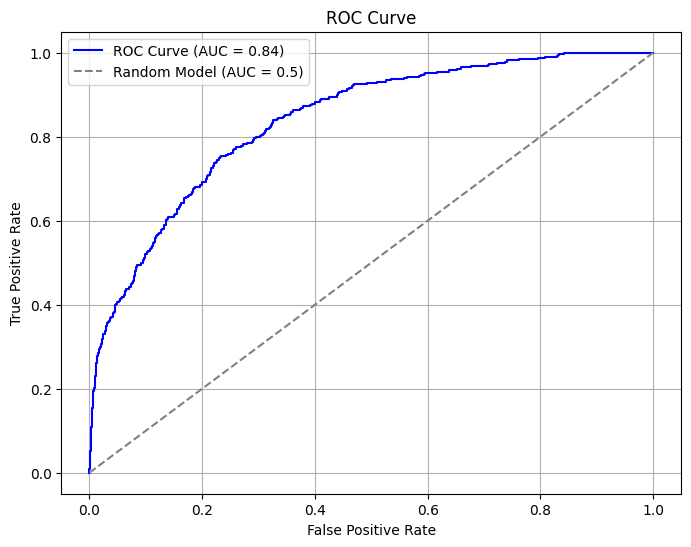

In [110]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Model (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

array([[1317,  246],
       [ 141,  237]])

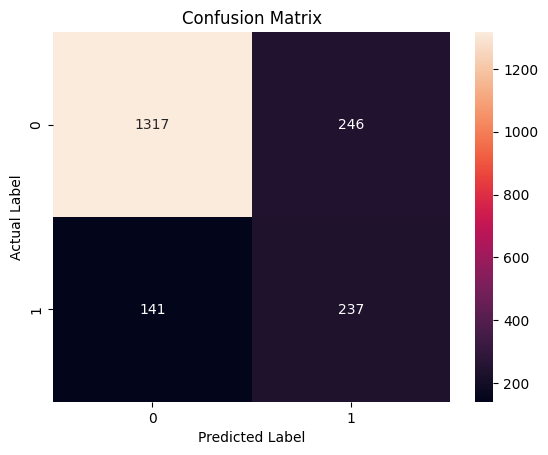

In [111]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
cm

In [113]:
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][1]
TN = cm[1][1]

In [115]:
recal = TP / (TP + FN)
precision = TP / (TP + FP)
accuracy = (TP + TN) / (TP + TN + FP + FN)
f1_score = (2 * recal * precision) / (recal + precision)

print(f"Recal : {recal:.2f}")
print(f"Precision : {precision:.2f}")
print(f"F1_score : {f1_score:.2f}")
print(f"Accuracy : {accuracy:.2f}")



Recal : 0.85
Precision : 0.84
F1_score : 0.85
Accuracy : 0.76


To ensure the model does not have underfitting or overfitting

In [116]:
y_train_pred = model.predict(x_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.86
Test Accuracy: 0.80
